In [80]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
from multinterp.unstructured import UnstructuredInterp

Suppose we have a collection of values for an unknown function along with their respective coordinate points. For illustration, assume the values come from the following function:


In [81]:
def function_1(u, v):
    return u * np.cos(u * v) + v * np.sin(u * v)

The points are randomly scattered within a square and therefore have no regular structure.


In [82]:
rng = np.random.default_rng(0)
rand_x, rand_y = rng.random((2, 1000)) * 3
values = function_1(rand_x, rand_y)

Now suppose we would like to interpolate this function on a rectilinear grid, which is known as "regridding".


In [83]:
grid_x, grid_y = np.meshgrid(
    np.linspace(0, 3, 100),
    np.linspace(0, 3, 100),
    indexing="ij",
)

To do this, we use `multinterp`'s `UnstructuredInterp` class. The class takes the following arguments:

- `values`: an ND-array of values for the function at the points
- `grids`: a list of ND-arrays of coordinates for the points
- `method`: the interpolation method to use, with options "nearest", "linear", "cubic" (for 2D only), and "rbf". The default is `'linear'`.

The `UnstructuredInterp` class is an object oriented wrapper around `scipy.interpolate`'s functions for multivariate interpolation on unstructured data, which are `NearestNDInterpolator`, `LinearNDInterpolator`, `CloughTocher2DInterpolator`, and `RBFInterpolator`. The advantage of using `multinterp`'s `UnstructuredInterp` class is that it provides a consistent interface for all of these methods, making it easier to switch between them and other interpolators in the `multinterp` package.


In [84]:
nearest_interp = UnstructuredInterp(values, (rand_x, rand_y), method="nearest")
linear_interp = UnstructuredInterp(values, (rand_x, rand_y), method="linear")
cubic_interp = UnstructuredInterp(values, (rand_x, rand_y), method="cubic")
rbf_interp = UnstructuredInterp(values, (rand_x, rand_y), method="rbf")

Once we create the interpolator objects, we can use them using the `__call__` method which takes as many arguments as there are dimensions.


In [85]:
nearest_grid = nearest_interp(grid_x, grid_y)
linear_grid = linear_interp(grid_x, grid_y)
cubic_grid = cubic_interp(grid_x, grid_y)
rbf_grid = rbf_interp(grid_x, grid_y)

Now we can compare the results of the interpolation with the original function. Below we plot the original function and the sample points that are known.


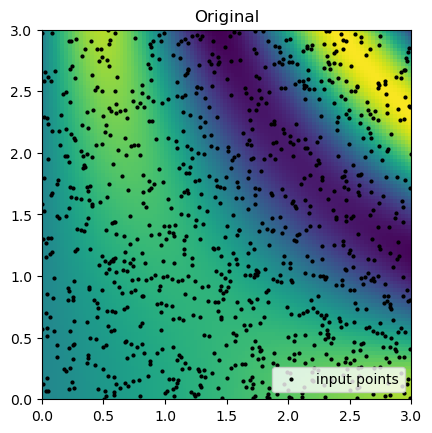

In [86]:
#| label: fig:unstructured_original

true_grid = function_1(grid_x, grid_y)
plt.imshow(true_grid.T, extent=(0, 3, 0, 3), origin="lower")
plt.plot(rand_x, rand_y, "ok", ms=2, label="input points")
plt.title("Original")
plt.legend(loc="lower right")

Then, we can look at the result for each method of interpolation and compare it to the original function.


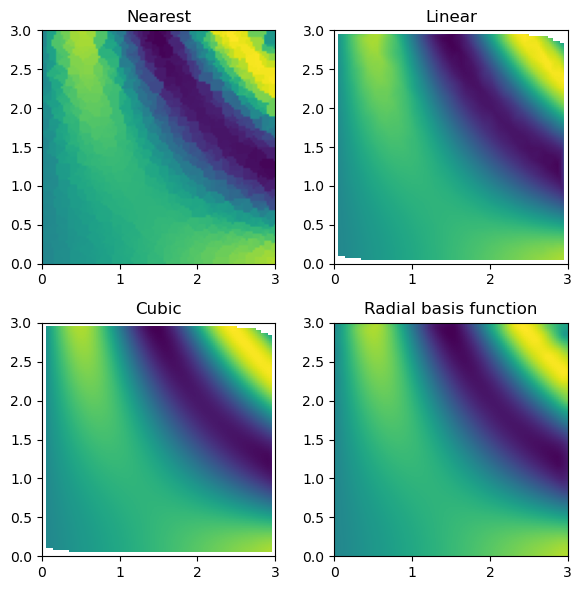

In [87]:
#| label: fig:unstructured_interpolated

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
titles = ["Nearest", "Linear", "Cubic", "Radial basis function"]
grids = [nearest_grid, linear_grid, cubic_grid, rbf_grid]

for ax, title, grid in zip(axs.flat, titles, grids):
    im = ax.imshow(grid.T, extent=(0, 3, 0, 3), origin="lower")
    ax.set_title(title)

plt.tight_layout()
plt.show()

Finally, `multinterp` also provides a set of interpolators organized around the concept of _regression_. As a demonstration, below we use a `RegressionUnstructuredInterp` interpolator which uses a Gaussian Process regression model from `scikit-learn` (@Pedregosa2011) to interpolate the function defined on the unstructured grid. The `RegressionUnstructuredInterp` class takes the same arguments as the `UnstructuredInterp` class, but it additionally requires the user to specify the regression `model` to use.


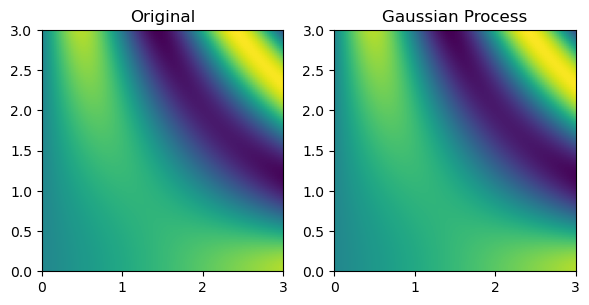

In [88]:
#| label: fig:unstructured_gp

from multinterp import RegressionUnstructuredInterp

gaussian_interp = RegressionUnstructuredInterp(
    values,
    (rand_x, rand_y),
    model="gaussian-process",
    std=True,
)

gaussian_grid = gaussian_interp(grid_x, grid_y)

fig, axs = plt.subplots(1, 2, figsize=(6, 6))
titles = ["Original", "Gaussian Process"]
grids = [true_grid, gaussian_grid]

for ax, title, grid in zip(axs.flat, titles, grids):
    im = ax.imshow(grid.T, extent=(0, 3, 0, 3), origin="lower")
    ax.set_title(title)

plt.tight_layout()
plt.show()